Environment setup

In [240]:
import os                         # for file locations
import matplotlib.pyplot as plt   # for plotting
import numpy as np                # arrays
import pickle                     # saving python objects
import pandas as pd               # dataframes
import tables


RANDOM_STATE = 0

# colours for printing outputs
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [242]:
!pip install h5py tables kaggle mne
!pip install --upgrade imbalanced-learn

Load Data

In [244]:
# Define the FILE_PATH variable with the actual path to your HDF5 file
FILE_PATH = "D:/New folder (2)/seizure-detection/dataset/Patient_2_features.h5"

# load features dataframe
h5file = tables.open_file(FILE_PATH, mode="r+")
h5file

File(filename=D:/New folder (2)/seizure-detection/dataset/Patient_2_features.h5, title='Patient 2 Features', mode='r+', root_uep='/', filters=Filters(complevel=0, shuffle=False, bitshuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) 'Patient 2 Features'
/Patient_2 (Group) 'Participant Data'
/Patient_2/Data_x (EArray(7035, 848)) 'Feature Array'
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (9, 848)
/Patient_2/Data_x_Feat_Names (Array(848,)) 'Names of Each Feature'
  atom := StringAtom(itemsize=29, shape=(), dflt=b'')
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := None
/Patient_2/Data_y (EArray(7035, 1)) 'Events Array'
  atom := Int64Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (8192, 1)

In [245]:
data_x = h5file.get_node('/Patient_2/Data_x')
data_y = h5file.get_node('/Patient_2/Data_y')
data_x_labels = h5file.get_node('/Patient_2/Data_x_Feat_Names')

part_feature_df = pd.DataFrame(data_x[:], columns = data_x_labels[:].astype(str))
part_feature_df['class'] = data_y[:]
part_feature_df = part_feature_df.set_index('class')
part_feature_df.head()

,LMacro_01|2_4Hz,LMacro_01|4_8Hz,LMacro_01|8_12Hz,LMacro_01|12_30Hz,LMacro_01|30_70Hz,LMacro_01|Ratio_3_12/2_30Hz,LMacro_01|D6_mean,LMacro_01|D5_mean,LMacro_01|D4_mean,LMacro_01|D3_mean,...,RMacro_04_RMacro_05|time_corr,RMacro_04_RMacro_06|time_corr,RMacro_04_RMacro_07|time_corr,RMacro_04_RMacro_08|time_corr,RMacro_05_RMacro_06|time_corr,RMacro_05_RMacro_07|time_corr,RMacro_05_RMacro_08|time_corr,RMacro_06_RMacro_07|time_corr,RMacro_06_RMacro_08|time_corr,RMacro_07_RMacro_08|time_corr
class,,,,,,,,,,,,,,,,,,,,,
1,227.771604,121.729376,104.748192,12.558394,0.647189,0.236310,-1.464481,-0.824742,0.013091,0.079837,...,0.273753,0.363735,0.389202,0.297462,0.789810,0.652605,0.519944,0.953851,0.796902,0.888274
1,162.957202,77.334727,39.298664,159.289935,17.511810,0.521757,-0.524147,-2.195927,0.170249,0.077665,...,0.402350,0.379938,0.046323,-0.029894,0.765875,0.426919,0.379509,0.808733,0.732159,0.911896
1,7.328949,42.812358,74.461760,98.214038,8.702826,0.631694,4.117210,-0.597011,-0.399529,0.090689,...,-0.020415,-0.103571,-0.071538,-0.048586,0.807652,0.638780,0.563594,0.936139,0.864730,0.954777
1,213.279844,85.966538,48.585487,241.390643,19.657826,1.773919,1.079959,0.292291,0.022378,0.049902,...,-0.194032,-0.129580,0.018119,0.232352,0.842868,0.673148,0.445052,0.857085,0.559804,0.861035
1,44.163924,27.442250,42.136054,177.165579,15.002302,1.353723,-1.712907,1.431398,-0.246839,-0.003639,...,0.099375,0.115953,0.158055,0.105109,0.680998,0.362963,0.242693,0.834629,0.653866,0.911919


Data Preparation

In [247]:
part_feature_df.index.value_counts()

class
2    3894
0    2990
1     151
Name: count, dtype: int64

In [248]:
reduced_features = part_feature_df.loc[[0,1]]
reduced_features.head()

,LMacro_01|2_4Hz,LMacro_01|4_8Hz,LMacro_01|8_12Hz,LMacro_01|12_30Hz,LMacro_01|30_70Hz,LMacro_01|Ratio_3_12/2_30Hz,LMacro_01|D6_mean,LMacro_01|D5_mean,LMacro_01|D4_mean,LMacro_01|D3_mean,...,RMacro_04_RMacro_05|time_corr,RMacro_04_RMacro_06|time_corr,RMacro_04_RMacro_07|time_corr,RMacro_04_RMacro_08|time_corr,RMacro_05_RMacro_06|time_corr,RMacro_05_RMacro_07|time_corr,RMacro_05_RMacro_08|time_corr,RMacro_06_RMacro_07|time_corr,RMacro_06_RMacro_08|time_corr,RMacro_07_RMacro_08|time_corr
class,,,,,,,,,,,,,,,,,,,,,
0,114.541010,26.387061,11.821119,1.357175,0.127231,0.080726,-0.128602,0.118216,-0.101168,-0.033279,...,-0.303116,-0.431413,-0.376480,-0.411506,0.544665,0.179166,0.469152,0.890269,0.827349,0.822477
0,27.574621,43.245174,18.910574,0.791160,0.113143,0.028620,-0.566416,-0.064466,-0.082230,0.007399,...,-0.427137,-0.388867,-0.327155,-0.370580,0.750489,0.593814,0.665086,0.956724,0.870345,0.912751
0,58.207500,18.142876,8.238157,1.537487,0.341276,0.179073,0.500630,-0.156088,0.016892,0.061672,...,0.121037,0.126031,0.092073,-0.025342,0.779517,0.483535,0.452129,0.887166,0.724896,0.718923
0,142.960698,11.285728,13.005110,1.014406,0.283393,0.118613,-0.823890,0.296830,0.030066,-0.039112,...,0.119059,0.116303,0.282626,0.113695,0.737446,0.529281,0.288499,0.719412,0.648070,0.786587
0,221.105230,39.302649,28.439736,3.143172,0.317358,0.072439,0.119001,0.103982,-0.235290,-0.002702,...,-0.272180,0.054720,-0.089779,0.077794,0.721609,0.470620,0.344036,0.810304,0.774646,0.820247


In [249]:
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.1
RANDOM_STATE = 0

# turn to numpy array
data_x = reduced_features.values

# create condition(group) array
data_y = reduced_features.index.values

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y,
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(2543, 848) (283, 848) (315, 848)
(2543,) (283,) (315,)


In [250]:
from sklearn.model_selection import train_test_split
TEST_SIZE = 0.1

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y,
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=TEST_SIZE,
                                                  random_state=RANDOM_STATE)

print(color.BOLD+color.UNDERLINE+'Feature DataFrame'+color.END)
print('Training size: ' + str(X_train.shape))
print('Validation size: ' + str(X_val.shape))
print('Test size: ' + str(X_test.shape))
print(color.BOLD+color.UNDERLINE+'\nTarget DataFrame'+color.END)
print('Training size: ' + str(y_train.shape))
print('Validation size: ' + str(y_val.shape))
print('Test size: ' + str(y_test.shape))

Feature DataFrame
Training size: (2543, 848)
Validation size: (283, 848)
Test size: (315, 848)

Target DataFrame
Training size: (2543,)
Validation size: (283,)
Test size: (315,)


In [251]:
def get_proportions(data):

    counts = pd.DataFrame(np.unique(data, return_counts=True), index = ['Class_ID', 'Counts']).T
    counts['Percent'] = (counts['Counts']/counts['Counts'].sum()).round(2)*100
    counts = counts.set_index('Class_ID')
    return counts


print(color.BOLD+color.UNDERLINE+'Training DataFrame'+color.END)
display(get_proportions(y_train))
print(color.BOLD+color.UNDERLINE+'\nTest DataFrame'+color.END)
display(get_proportions(y_test))

Training DataFrame


,Counts,Percent
Class_ID,,
0,2412,95.0
1,131,5.0



Test DataFrame


,Counts,Percent
Class_ID,,
0,308,98.0
1,7,2.0


In [252]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)

Balancing the Classes

In [254]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming X_train is your training data and 'reduced_features' is your DataFrame
# containing features
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train) # Scale X_train and assign it to X_train_scale

x_axis_label = 'LMacro_03|D4_ratio'
y_axis_label = 'LMacro_03|D2_ratio'

# Define feature_list using the columns of reduced_features DataFrame
feature_list = reduced_features.columns.tolist()

# Now you can use X_train_scale and feature_list
reduced_array = X_train_scale[:,[feature_list.index(x_axis_label),feature_list.index(y_axis_label)]]
reduced_df = pd.DataFrame(reduced_array, columns=[x_axis_label, y_axis_label])

reduced_df.head()

,LMacro_03|D4_ratio,LMacro_03|D2_ratio
0,-0.299454,0.829181
1,0.153427,-0.357728
2,0.749223,-1.195375
3,1.040002,-0.645158
4,0.225496,-0.972399


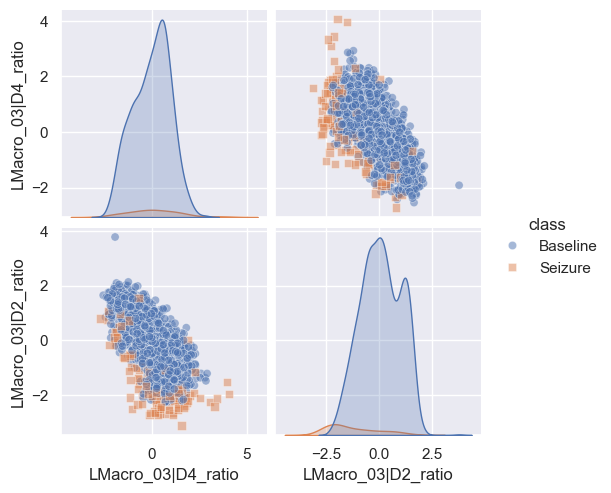

In [255]:
import seaborn as sns; sns.set(color_codes=True)

def plot_pairplot(data_x, data_y):

    data_plot = data_x.copy()
    data_plot['class'] = np.vectorize({0:'Baseline', 1:'Seizure'}.get)(data_y)
    sns.pairplot(data_plot,
                 hue = 'class',
                 hue_order = ['Baseline','Seizure'],
                 markers=["o", "s"],
                 plot_kws=dict(alpha = 0.5))
    plt.show()

plot_pairplot(reduced_df, y_train)

Under-Sampling

Resample

Before Resample
Counter({0: 2412, 1: 131})


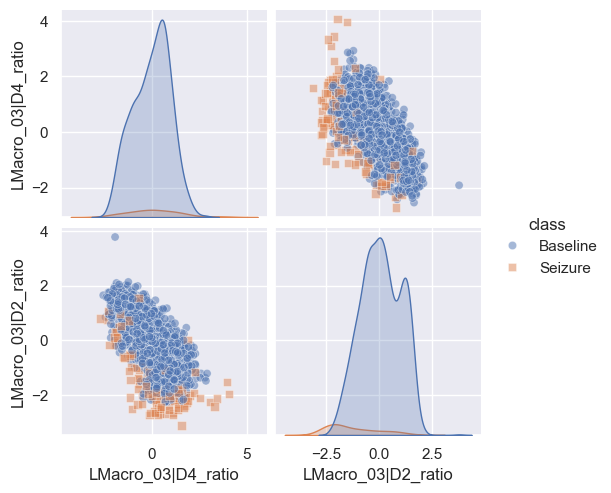

After Resample
Counter({1: 131, 0: 131})


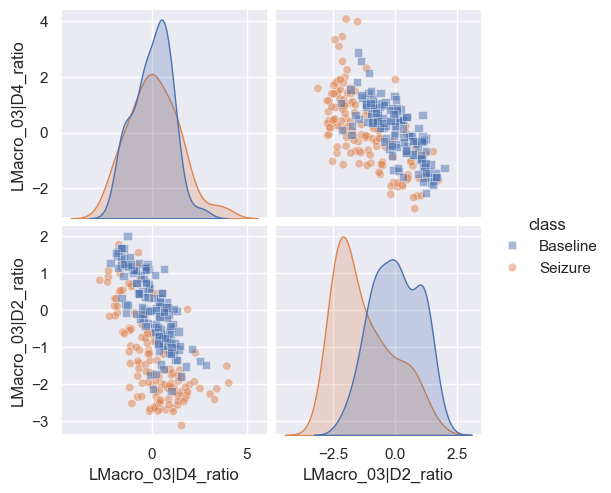

In [258]:
from sklearn.utils import resample
from collections import Counter

print(color.UNDERLINE + 'Before Resample' + color.END)
print(Counter(y_train))
plot_pairplot(reduced_df, y_train)

print(color.UNDERLINE + 'After Resample' + color.END)
data_x_downsampled, data_y_downsampled = resample(reduced_df[y_train == 0],
                                                  y_train[y_train == 0],
                                                  replace=True,
                                                  n_samples=reduced_df[y_train == 1].shape[0],
                                                  random_state=123)

data_x_bal = np.vstack((reduced_df[y_train == 1], data_x_downsampled))
data_y_bal = np.hstack((y_train[y_train == 1], data_y_downsampled))
print(Counter(data_y_bal))

plot_pairplot(pd.DataFrame(data_x_bal, columns = reduced_df.columns),
              pd.DataFrame(data_y_bal))

RandomUnderSampler

Before Resample
Counter({0: 2412, 1: 131})


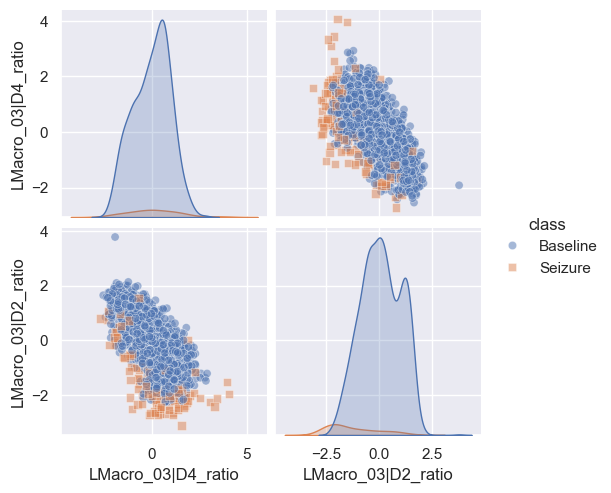

After Resample
Counter({0: 131, 1: 131})


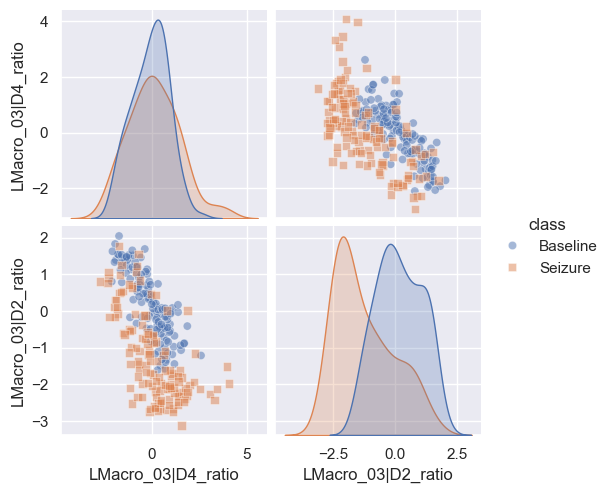

In [260]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

def imblearn_sample(sampler, data_x, data_y):

    print(color.UNDERLINE + 'Before Resample' + color.END)
    print(Counter(data_y))
    plot_pairplot(data_x, data_y)

    print(color.UNDERLINE + 'After Resample' + color.END)
    data_x_downsampled, data_y_downsampled = sampler.fit_resample(data_x,
                                                                data_y)
    print(Counter(data_y_downsampled))

    plot_pairplot(pd.DataFrame(data_x_downsampled, columns = data_x.columns),
                  pd.DataFrame(data_y_downsampled))

imblearn_sample(RandomUnderSampler(random_state=123), reduced_df, y_train)

Over-Sampling

RandomOverSampler

Before Resample
Counter({0: 2412, 1: 131})


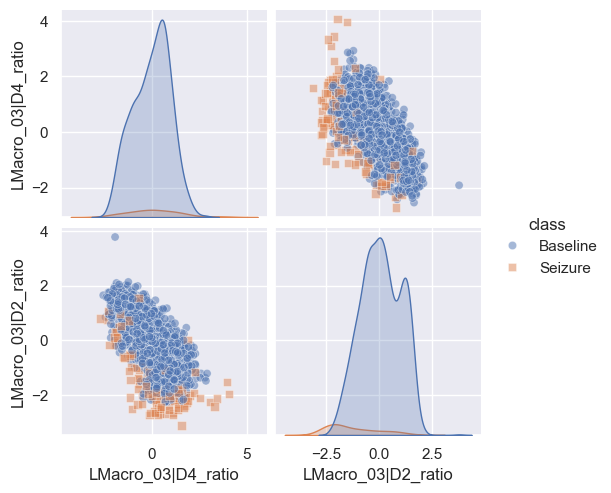

After Resample
Counter({0: 2412, 1: 2412})


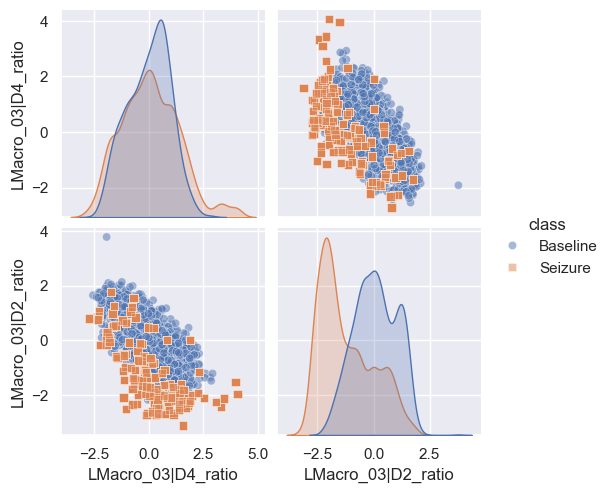

In [263]:
from imblearn.over_sampling import RandomOverSampler

imblearn_sample(RandomOverSampler(random_state=123), reduced_df, y_train)

ADASYN and SMOTE

SMOTE
Before Resample
Counter({0: 2412, 1: 131})


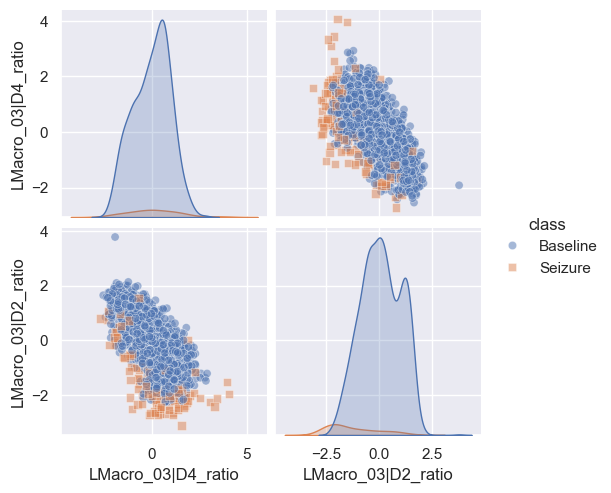

After Resample
Counter({0: 2412, 1: 2412})


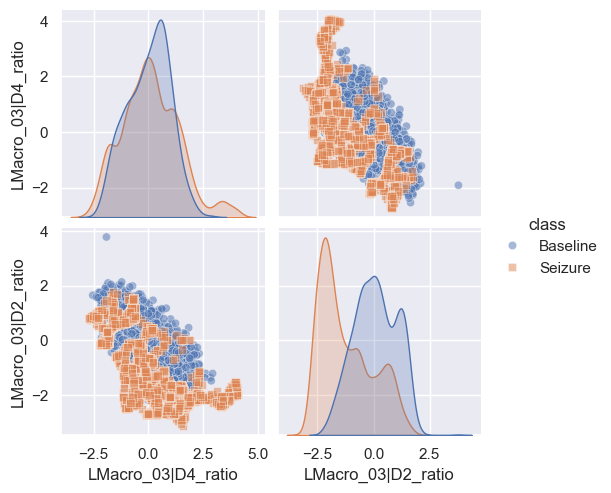

ADASYN
Before Resample
Counter({0: 2412, 1: 131})


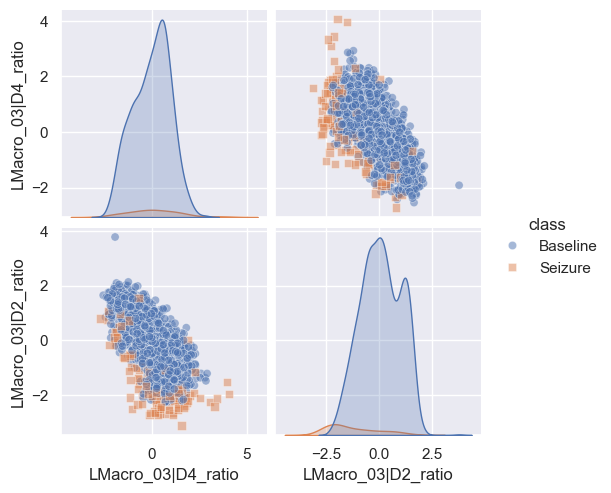

After Resample
Counter({0: 2412, 1: 2408})


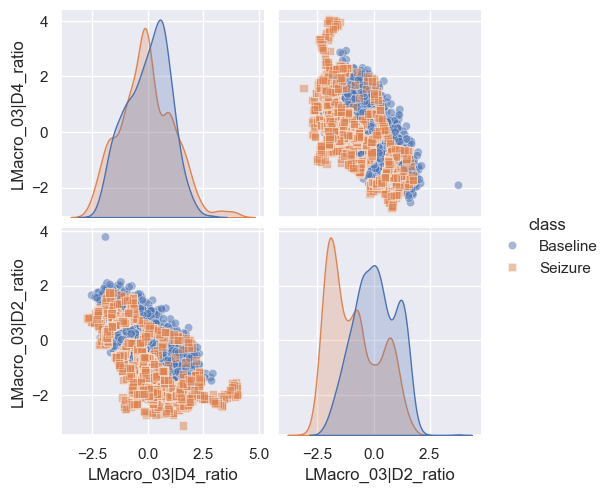

SMOTE with Edited Nearest Neighbor
Before Resample
Counter({0: 2412, 1: 131})


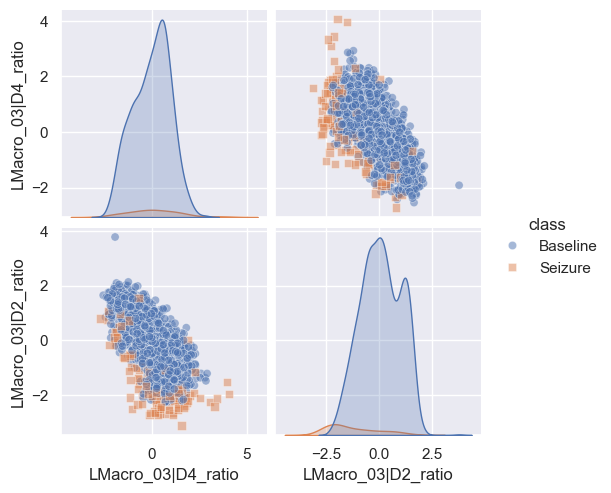

After Resample
Counter({1: 1928, 0: 1867})


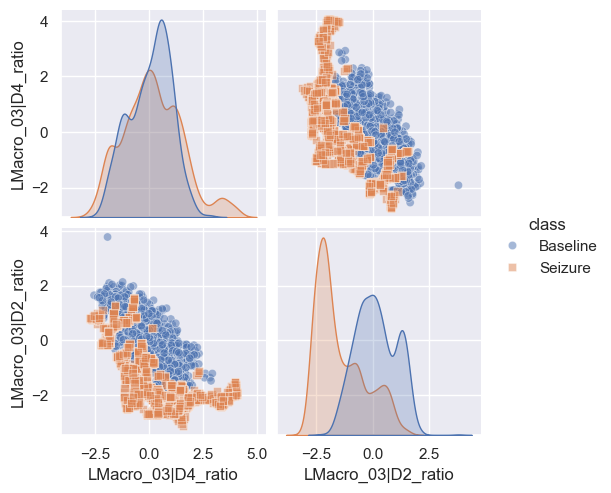

SMOTE with Tomek links
Before Resample
Counter({0: 2412, 1: 131})


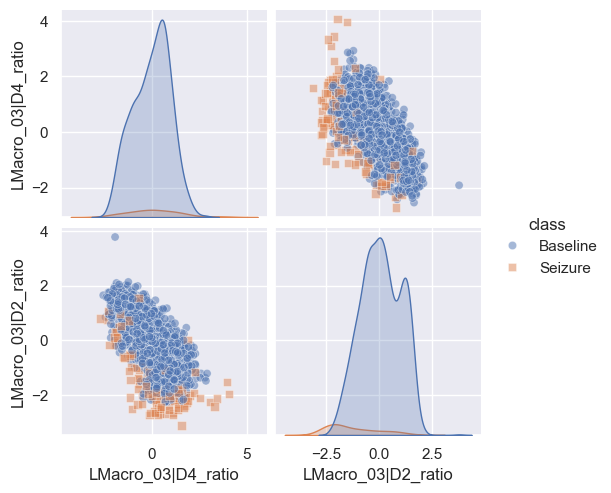

After Resample
Counter({0: 2283, 1: 2283})


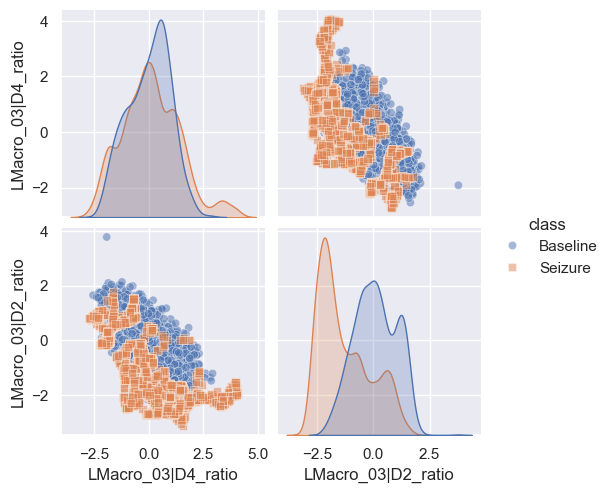

In [265]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek

print(color.BOLD+color.UNDERLINE+'SMOTE'+color.END)
imblearn_sample(SMOTE(random_state=123), reduced_df, y_train)
print(color.BOLD+color.UNDERLINE+'ADASYN'+color.END)
imblearn_sample(ADASYN(random_state=123), reduced_df, y_train)
print(color.BOLD+color.UNDERLINE+'SMOTE with Edited Nearest Neighbor'+color.END)
imblearn_sample(SMOTEENN(random_state=123), reduced_df, y_train)
print(color.BOLD+color.UNDERLINE+'SMOTE with Tomek links'+color.END)
imblearn_sample(SMOTETomek(random_state=123), reduced_df, y_train)

Binary Classification

Logistic Regression

In [268]:
from sklearn.linear_model import LogisticRegression

reg = LogisticRegression(C=100.,
                         solver='liblinear',
                         random_state=RANDOM_STATE)

reg.fit(X_train_scale, y_train)

LogisticRegression(C=100.0, random_state=0, solver='liblinear')

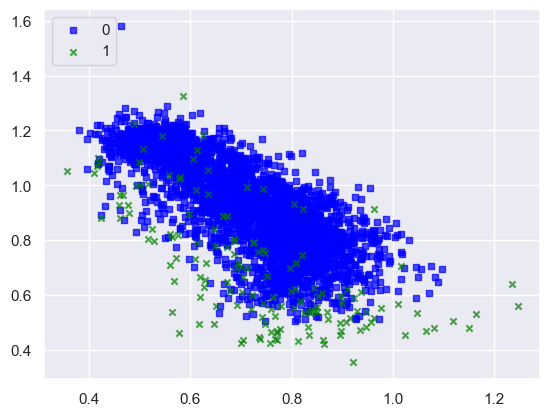

In [269]:
from mlxtend.plotting import category_scatter

x_axis_label = 'LMacro_03|D4_ratio'
y_axis_label = 'LMacro_03|D2_ratio'

reduced_features_reset = reduced_features.reset_index()

fig = category_scatter(x=x_axis_label, y=y_axis_label, label_col='class',
                     data=reduced_features_reset, legend_loc='upper left')

feature_list = list(reduced_features.columns)
vis_data = X_train_scale[:,[feature_list.index(x_axis_label),
                          feature_list.index(y_axis_label)]]

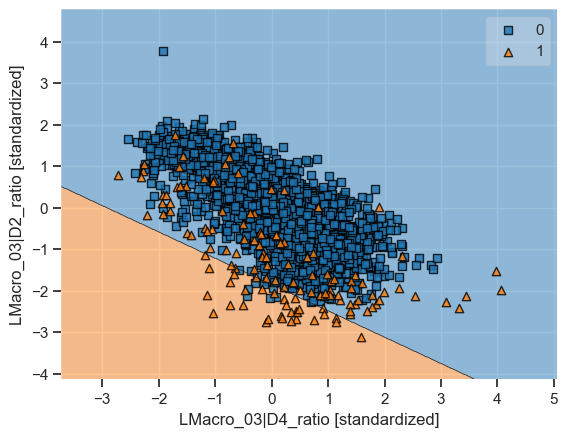

In [270]:
from mlxtend.plotting import plot_decision_regions

reg.fit(vis_data, y_train)

plot_decision_regions(vis_data,
                      y_train,
                      clf = reg)

plt.xlabel(x_axis_label + ' [standardized]')
plt.ylabel(y_axis_label + ' [standardized]')
plt.show()

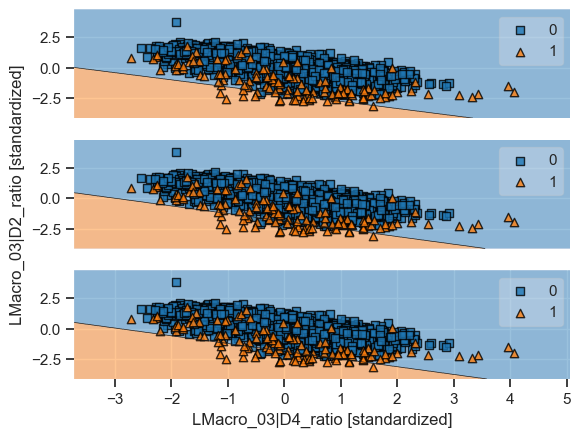

In [271]:
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True)

for i, c in enumerate([0.1, 1, 10]):
    reg = LogisticRegression(C=c, solver='liblinear',random_state=RANDOM_STATE)

    reg.fit(vis_data, y_train)

    plot_decision_regions(vis_data,
                          y_train,
                          clf = reg,
                          ax = axes[i])
    axes[i].get_xaxis().set_visible(False)

axes[2].get_xaxis().set_visible(True)
plt.xlabel(x_axis_label + ' [standardized]')
axes[1].set_ylabel(y_axis_label + ' [standardized]')
plt.savefig('log_change_reg.png')
plt.show()

In [272]:
from sklearn.pipeline import Pipeline

pipe_reg = Pipeline([('scl', StandardScaler()),
                     ('clf', LogisticRegression(C=100,
                                                solver='liblinear',
                                                class_weight='balanced',
                                                random_state=RANDOM_STATE))])

pipe_reg

Pipeline(steps=[('scl', StandardScaler()),
                ('clf',
                 LogisticRegression(C=100, class_weight='balanced',
                                    random_state=0, solver='liblinear'))])

In [273]:
pipe_reg.fit(X_train, y_train)
print('Validation Accuracy: %.3f' % pipe_reg.score(X_val, y_val))

Validation Accuracy: 0.989


In [274]:
log_predicted = pipe_reg.predict(X_val)
log_predicted

array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
      dtype=int64)

In [275]:
y_val

array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
      dtype=int64)

Support Vector Machine (SVM)

In [277]:
from sklearn.svm import SVC

pipe_svc_linear = Pipeline([('scl', StandardScaler()),
                            ('clf', SVC(C=100,
                                        kernel='linear',
                                        class_weight = 'balanced',
                                        random_state=RANDOM_STATE))])

pipe_svc_linear

Pipeline(steps=[('scl', StandardScaler()),
                ('clf',
                 SVC(C=100, class_weight='balanced', kernel='linear',
                     random_state=0))])

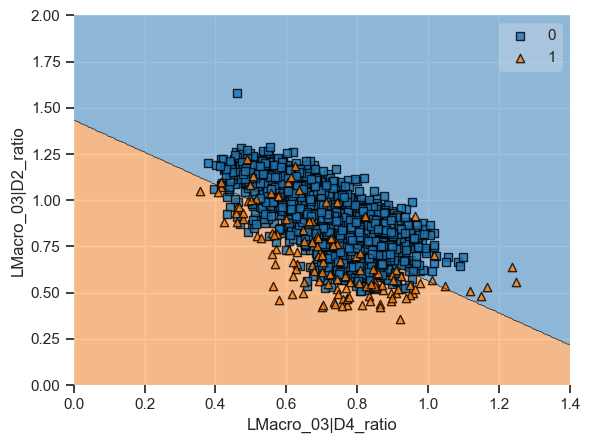

In [278]:
from mlxtend.plotting import plot_decision_regions

vis_data = X_train[:,[feature_list.index(x_axis_label),
                      feature_list.index(y_axis_label)]]

pipe_svc_linear.fit(vis_data, y_train)

plot_decision_regions(vis_data,
                      y_train,
                      clf = pipe_svc_linear)

plt.xlabel(x_axis_label)
plt.ylabel(y_axis_label)
plt.xlim(0,1.4)
plt.ylim(0,2)

plt.savefig('svm_linear_boundary.png')
plt.show()

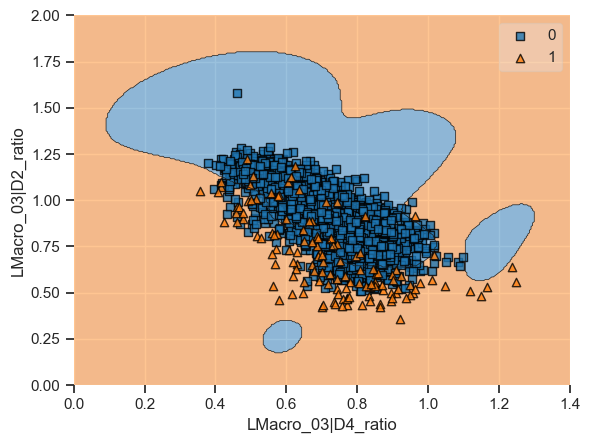

In [279]:
pipe_svc_rbf = Pipeline([('scl', StandardScaler()),
                         ('clf', SVC(C=100,
                                     kernel='rbf',
                                     class_weight = 'balanced',
                                     random_state=RANDOM_STATE))])

pipe_svc_rbf.fit(vis_data, y_train)

plot_decision_regions(vis_data,
                      y_train,
                      clf = pipe_svc_rbf)

plt.xlabel(x_axis_label)
plt.ylabel(y_axis_label)
plt.xlim(0,1.4)
plt.ylim(0,2)

plt.savefig('svm_rbf_boundary.png')
plt.show()

In [280]:
pipe_svc_rbf.fit(X_train, y_train)
print('Validation Accuracy: %.3f' % pipe_svc_rbf.score(X_val, y_val))

Validation Accuracy: 0.993


Decision Tree

In [349]:
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier(criterion='gini',
                            max_depth = 1,
                            random_state=RANDOM_STATE)

DT

DecisionTreeClassifier(max_depth=1, random_state=0)

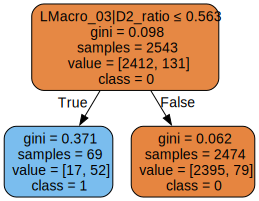

In [353]:
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data
import graphviz

DT.fit(vis_data, y_train)

class_names = [str(name) for name in list(set(y_train))]

dot_data = export_graphviz(DT, out_file=None,
                     feature_names=[x_axis_label, y_axis_label],
                     class_names=class_names,
                     filled=True, rounded=True,
                     special_characters=True)

# Save it
graph = graph_from_dot_data(dot_data)
graph.write_png('binary_split.png')

# Show it
graphviz.Source(dot_data)

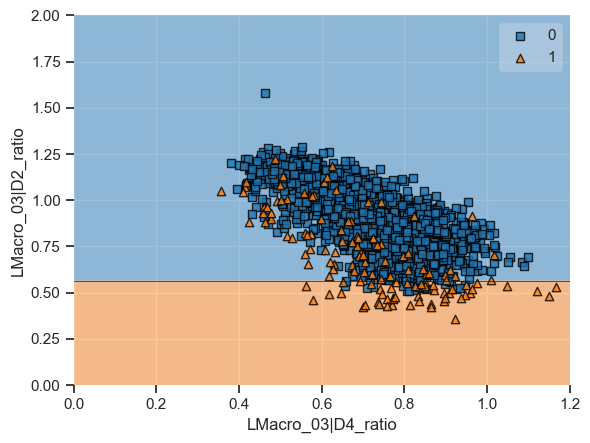

In [343]:
plot_decision_regions(vis_data,
                      y_train,
                      clf = DT)

plt.xlabel(x_axis_label)
plt.ylabel(y_axis_label)
plt.xlim(0,1.2)
plt.ylim(0,2.)
plt.show()

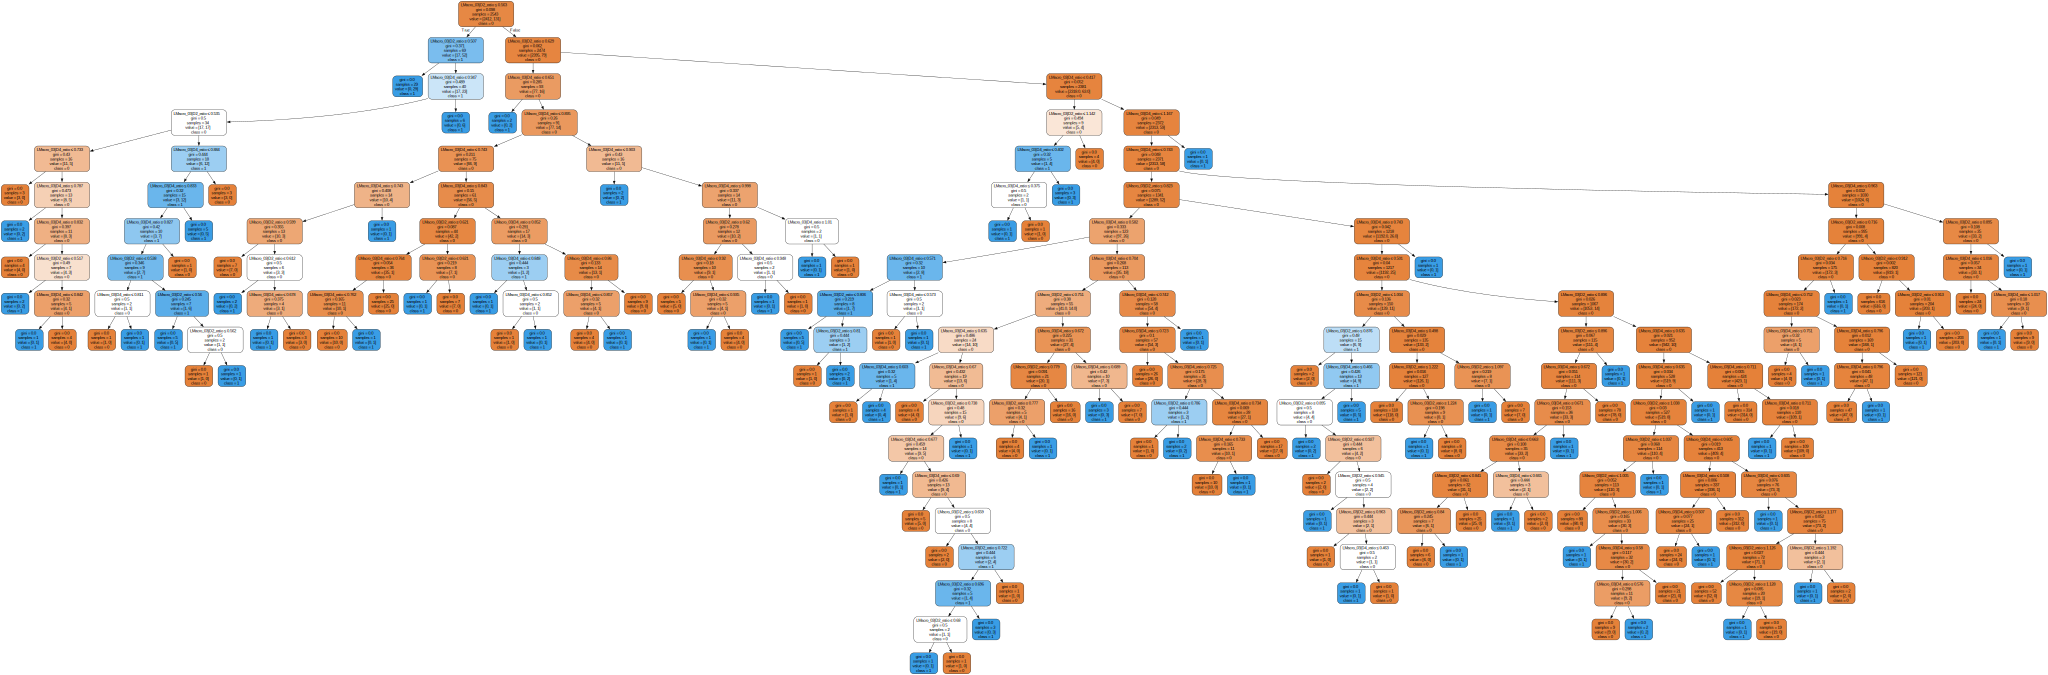

In [345]:
DT = DecisionTreeClassifier(criterion='gini',
                            max_depth = None,
                            random_state=RANDOM_STATE)
DT.fit(vis_data, y_train)

class_names = [str(name) for name in list(set(y_train))]

dot_data = export_graphviz(DT, out_file=None,
                     feature_names=[x_axis_label, y_axis_label],
                     class_names=class_names,
                     filled=True, rounded=True,
                     special_characters=True)

# Save it
graph = graph_from_dot_data(dot_data)
graph.write_png('multi_split.png')

# Show it
graphviz.Source(dot_data)

In [363]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Example of applying scaling and PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

pca = PCA(n_components=2)  # Assuming you want to reduce to 2 features
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

# Fit the model with the PCA-transformed data
DT = DecisionTreeClassifier()
DT.fit(X_train_pca, y_train)

# Evaluate on the validation set
print('Validation Accuracy: %.3f' % DT.score(X_val_pca, y_val))


Validation Accuracy: 0.929


K-Nearest Neighbors

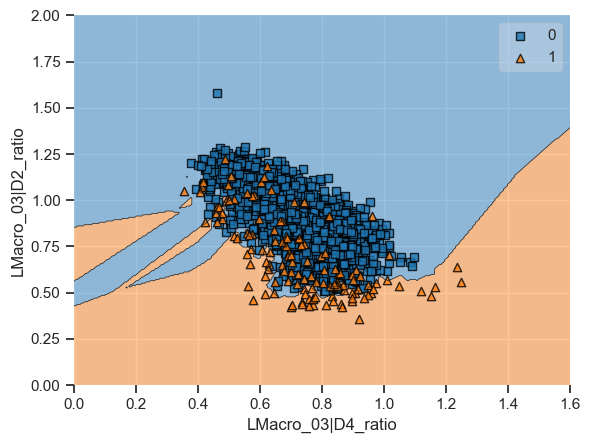

In [315]:
from sklearn.neighbors import KNeighborsClassifier
pipe_knn = Pipeline([('scl', StandardScaler()),
                     ('clf', KNeighborsClassifier(n_neighbors=2))])

pipe_knn.fit(vis_data, y_train)

plot_decision_regions(vis_data,
                      y_train,
                      clf = pipe_knn)

plt.xlabel(x_axis_label)
plt.ylabel(y_axis_label)
plt.xlim(0,1.6)
plt.ylim(0,2.)
plt.show()

In [319]:
pipe_knn.fit(X_train, y_train)
print('Validation Accuracy: %.3f' % pipe_knn.score(X_val, y_val))

Validation Accuracy: 0.986


Model Evaluation

In [322]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Logistic Regression
pipe_reg = Pipeline([('scl', StandardScaler()),
                     ('clf', LogisticRegression(class_weight='balanced',
                                                solver = 'liblinear',
                                                random_state=RANDOM_STATE))])

# Support Vector Machine
pipe_svc = Pipeline([('scl', StandardScaler()),
                    ('clf', SVC(kernel='rbf',
                                class_weight = 'balanced',
                                probability=True,
                                random_state=RANDOM_STATE))])

# Decision Tree
DT = DecisionTreeClassifier(random_state=RANDOM_STATE)

# K-Nearest Neighbours
pipe_kkn = Pipeline([('scl', StandardScaler()),
                    ('clf', KNeighborsClassifier())])

# list of classifier names
classifier_names = ['Logistic Regression', 'Support Vector Machine',
                    'Decision Tree', 'K-Nearest Neighbors']

# list of classifiers
classifiers = [pipe_reg, pipe_svc, DT, pipe_kkn]

# fit all the classifiers to the training data
for classifier in classifiers:
  classifier.fit(X_train, y_train)

C:\Users\HP\AppData\Local\Temp\ipykernel_956\69081637.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+['Baseline', 'Seizure'])
C:\Users\HP\AppData\Local\Temp\ipykernel_956\69081637.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+['Baseline', 'Seizure'])


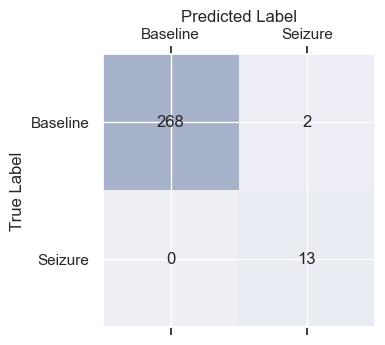

In [323]:
from sklearn.metrics import confusion_matrix

def pretty_confusion_matrix(confmat):

    # this creates the matplotlib graph to make the confmat look nicer
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    # change the labels
    ax.set_xticklabels(['']+['Baseline', 'Seizure'])
    ax.set_yticklabels(['']+['Baseline', 'Seizure'])

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    ax.xaxis.set_label_position('top')

    plt.tight_layout()

    plt.show()


# use the first classifier to predict the validation set
predictions = classifiers[1].predict(X_val)

# get the confusion matrix as a numpy array
confmat = confusion_matrix(y_true=y_val, y_pred=predictions)

# use the pretty function to make it nicer
pretty_confusion_matrix(confmat)

In [324]:
FP = confmat[0,1]
TN = confmat[0,0]
TP = confmat[1,1]
FN = confmat[1,0]

ERR = (FP+FN)/(FP+FN+TP+TN)
ACC = 1-ERR
TPR = TP/(FN+TP)
FPR = FP/(FP+TN)
PRE = TP/(TP+FP)
REC = TP/(FN+TP)
F1 = 2*((PRE*REC)/(PRE+REC))

print('True positive rate (TPR): %.3f' % TPR)
print('False positive rate (FPR): %.3f' % FPR)
print('Error (ERR): %.3f' % ERR)
print()
print('Accuracy (ACC): %.3f' % ACC)
print('Precision (PRE): %.3f' % PRE)
print('Recall (REC): %.3f' % REC)
print('F1-score (F1): %.3f' % F1)

True positive rate (TPR): 1.000
False positive rate (FPR): 0.007
Error (ERR): 0.007

Accuracy (ACC): 0.993
Precision (PRE): 0.867
Recall (REC): 1.000
F1-score (F1): 0.929


In [325]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score

print('Accuracy (ACC): %.3f' % accuracy_score(y_true=y_val, y_pred=predictions))
print('Precision (PRE): %.3f' % precision_score(y_true=y_val, y_pred=predictions))
print('Recall (REC): %.3f' % recall_score(y_true=y_val, y_pred=predictions))
print('F1-score (F1): %.3f' % f1_score(y_true=y_val, y_pred=predictions))

Accuracy (ACC): 0.993
Precision (PRE): 0.867
Recall (REC): 1.000
F1-score (F1): 0.929


In [326]:
from sklearn.metrics import classification_report

pd.DataFrame(classification_report(y_val,
                                   predictions,
                                   labels=None,
                                   target_names=['Baseline', 'Seizure'],
                                   sample_weight=None,
                                   digits=2,
                                   output_dict=True))

,Baseline,Seizure,accuracy,macro avg,weighted avg
precision,1.000000,0.866667,0.992933,0.933333,0.993875
recall,0.992593,1.000000,0.992933,0.996296,0.992933
f1-score,0.996283,0.928571,0.992933,0.962427,0.993172
support,270.000000,13.000000,0.992933,283.000000,283.000000


C:\Users\HP\AppData\Local\Temp\ipykernel_956\69081637.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+['Baseline', 'Seizure'])
C:\Users\HP\AppData\Local\Temp\ipykernel_956\69081637.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+['Baseline', 'Seizure'])


Logistic Regression


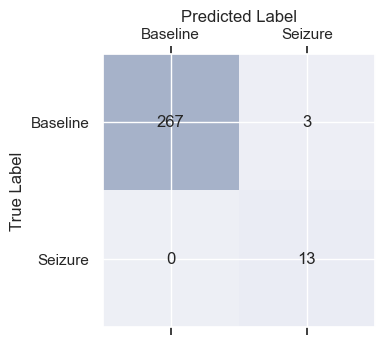

Support Vector Machine


C:\Users\HP\AppData\Local\Temp\ipykernel_956\69081637.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+['Baseline', 'Seizure'])
C:\Users\HP\AppData\Local\Temp\ipykernel_956\69081637.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+['Baseline', 'Seizure'])


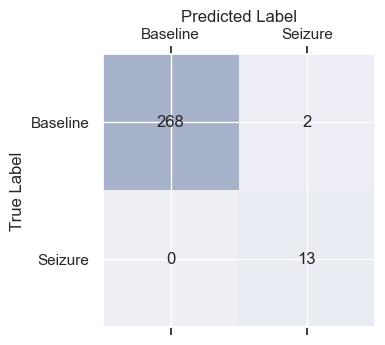

C:\Users\HP\AppData\Local\Temp\ipykernel_956\69081637.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+['Baseline', 'Seizure'])
C:\Users\HP\AppData\Local\Temp\ipykernel_956\69081637.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+['Baseline', 'Seizure'])


Decision Tree


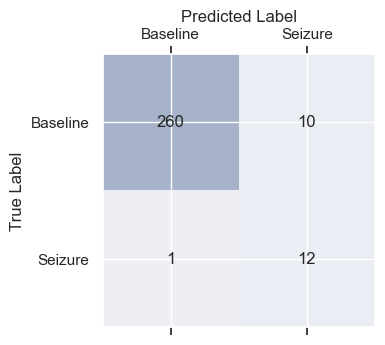

K-Nearest Neighbors


C:\Users\HP\AppData\Local\Temp\ipykernel_956\69081637.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+['Baseline', 'Seizure'])
C:\Users\HP\AppData\Local\Temp\ipykernel_956\69081637.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+['Baseline', 'Seizure'])


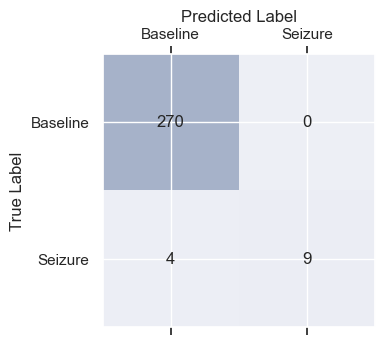

In [327]:
for i, classifier in enumerate(classifiers):
  print(color.BOLD+color.UNDERLINE+classifier_names[i]+color.END)

  predictions = classifier.predict(X_val)

  confmat = confusion_matrix(y_true=y_val, y_pred=predictions)

  pretty_confusion_matrix(confmat)

In [328]:
for i, classifier in enumerate(classifiers):
  predictions = classifier.predict(X_val)

  classifier_score_df = pd.DataFrame(
      classification_report(y_val,
                            predictions,
                            target_names=['Baseline', 'Seizure'],
                            digits=2,
                            output_dict=True))

  classifier_score_df.index.name = 'Metric'
  classifier_score_df['Classifier'] = classifier_names[i]
  classifier_score_df = classifier_score_df.set_index('Classifier', append=True)

  if i == 0:
    all_scores = classifier_score_df

  else:
    all_scores = pd.concat([all_scores, classifier_score_df])

all_scores.sort_index()

Baseline    Seizure  accuracy   macro avg  \
Metric    Classifier                                                            
f1-score  Decision Tree             0.979284   0.685714  0.961131    0.832499   
          K-Nearest Neighbors       0.992647   0.818182  0.985866    0.905414   
          Logistic Regression       0.994413   0.896552  0.989399    0.945483   
          Support Vector Machine    0.996283   0.928571  0.992933    0.962427   
precision Decision Tree             0.996169   0.545455  0.961131    0.770812   
          K-Nearest Neighbors       0.985401   1.000000  0.985866    0.992701   
          Logistic Regression       1.000000   0.812500  0.989399    0.906250   
          Support Vector Machine    1.000000   0.866667  0.992933    0.933333   
recall    Decision Tree             0.962963   0.923077  0.961131    0.943020   
          K-Nearest Neighbors       1.000000   0.692308  0.985866    0.846154   
          Logistic Regression       0.988889   1.000000  0.989399    0.994444   
          Support Vector Machine    0.992593   1.000000  0.992933    0.996296   
support   Decision Tree           270.000000  13.000000  0.961131  283.000000   
          K-Nearest Neighbors     270.000000  13.000000  0.985866  283.000000   
          Logistic Regression     270.000000  13.000000  0.989399  283.000000   
          Support Vector Machine  270.000000  13.000000  0.992933  283.000000   

                                  weighted avg  
Metric    Classifier                            
f1-score  Decision Tree               0.965799  
          K-Nearest Neighbors         0.984633  
          Logistic Regression         0.989918  
          Support Vector Machine      0.993172  
precision Decision Tree               0.975464  
          K-Nearest Neighbors         0.986072  
          Logistic Regression         0.991387  
          Support Vector Machine      0.993875  
recall    Decision Tree               0.961131  
          K-Nearest Neighbors         0.985866  
          Logistic Regression         0.989399  
          Support Vector Machine      0.992933  
support   Decision Tree             283.000000  
          K-Nearest Neighbors       283.000000  
          Logistic Regression       283.000000  
          Support Vector Machine    283.000000

Receiver Operating Characteristic (ROC) Curve

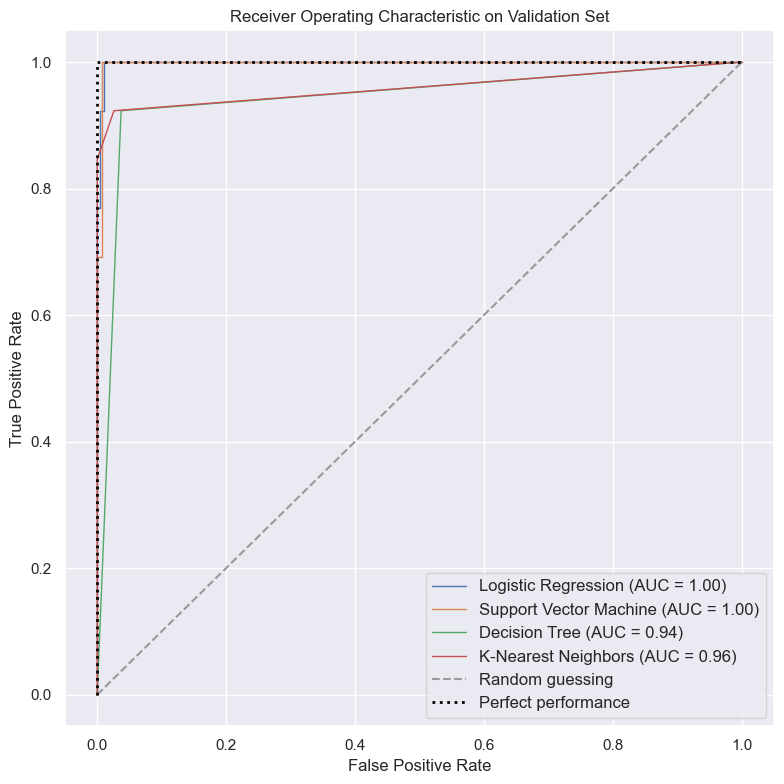

In [330]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def ROC(classifiers, classifier_names, X_train, X_val, y_train, y_val, image_file_path):
    """
    Plot the ROC curve for multiple classifiers and save the image to a specified file path.

    Parameters:
    - classifiers: List of classifier models to evaluate.
    - classifier_names: List of names corresponding to the classifiers.
    - X_train, X_val: Training and validation feature sets.
    - y_train, y_val: Training and validation labels.
    - image_file_path: Path to save the ROC curve plot.
    """
    # Set up the plot
    fig, ax = plt.subplots(figsize=(8, 8))

    # Iterate over each classifier
    for i, classifier in enumerate(classifiers):
        # Fit the classifier and predict probabilities for validation set
        probas = classifier.fit(X_train, y_train).predict_proba(X_val)

        # Get the ROC curve metrics
        fpr, tpr, thresholds = roc_curve(y_val, probas[:, 1], pos_label=1)
        roc_auc = auc(fpr, tpr)

        # Plot the ROC curve for each classifier
        ax.plot(fpr, tpr, lw=1, label='{} (AUC = {:.2f})'.format(classifier_names[i], roc_auc))

    # Plot random guessing line
    ax.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='Random guessing')

    # Plot perfect performance line
    ax.plot([0, 0, 1], [0, 1, 1], lw=2, linestyle=':', color='black', label='Perfect performance')

    # Set plot limits and labels
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic on Validation Set')
    ax.legend(loc="lower right", fontsize='medium')

    # Save and display the plot
    plt.tight_layout()
    plt.savefig(image_file_path, dpi=300)
    plt.show()

ROC(classifiers, classifier_names, X_train, X_val, y_train,
    y_val, 'Classifiers_ROC.png')